In [1]:
import sys
sys.path.append('../')

import tquant as tq
import tensorflow as tf

# from datetime import date, timedelta
# import tensorflow as tf
# import pandas as pd
from datastore import *

tq.Settings.evaluation_date = date(2024, 4, 30)

In [2]:
rc0 = tq.RateCurve(ir_eur_curve_estr['daycount'].values/365, ir_eur_curve_estr['quote'].values)
rc = tq.RateCurveTest(ir_eur_curve_estr['daycount'].values/365, ir_eur_curve_estr['quote'].values, 'LINEAR')

In [8]:
term = 10
rc.discount(term) == rc0.discount(term)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [2]:
def modifica_stringhe(lista_stringhe):
    # Lista per memorizzare le stringhe modificate
    stringhe_modificate = []
    
    # Rimozione del prefisso FRA
    prefisso = "FRA-"
    for stringa in lista_stringhe:
        if stringa.startswith(prefisso):
            stringa = stringa[len(prefisso):]
        stringhe_modificate.append(stringa)

    # Dizionario delle sostituzioni
    sostituzioni = {
        "1BD": "O/N",
        "2BD": "T/N",
        "3BD": "S/N",
        "CASH": "depo",
        "SWAP": "ois",
        "FRA": "fra",
    }

    # Lista temporanea per memorizzare le stringhe modificate ulteriormente
    stringhe_modificate_finali = []

    # Iterare su ciascuna stringa nella lista delle stringhe modificate
    for stringa in stringhe_modificate:
        for chiave, valore in sostituzioni.items():
            stringa = stringa.replace(chiave, valore)
        stringhe_modificate_finali.append(stringa)
    
    return stringhe_modificate_finali

In [3]:
#bootstrap della estr
generators = modifica_stringhe(ir_eur_curve_estr['type'])
maturities = list(modifica_stringhe(ir_eur_curve_estr['tenor']))
data = [["EUR", "DISCOUNT", "", "EUR:ESTR"]]
attributes = ["CCY", "USAGE"]
curve_assignment = tq.CurveAssignment(data, attributes)

deposit_builder = tq.DepositHelper(tq.Currency.EUR,
                    2,
                    tq.BusinessDayConvention.ModifiedFollowing,
                    tq.DayCounterConvention.Actual360,
                    1.0)

ois_builder = tq.OisHelper(tq.Currency.EUR,
                        2,
                        2,
                        "1Y",
                        "1Y",
                        tq.BusinessDayConvention.ModifiedFollowing,
                        1.0,
                        tq.DayCounterConvention.Actual360,
                        tq.DayCounterConvention.Actual360)

generator_map = {"depo": deposit_builder,
                 "ois": ois_builder}

# PricerFactory

In [4]:
from abc import abstractmethod
from datetime import timedelta
import datetime

class AbstractPricer:
    @abstractmethod
    def price(self,
              product: tq.Product,
              trade_date: date,
              curves: dict[str, tq.RateCurve]):
        pass

class DepositPricer(AbstractPricer):
    def __init__(self,
                 curve_assignment: tq.CurveAssignment):
        super().__init__()
        self.curve_assignment = curve_assignment

    def price(self,
              product: tq.Product,
              as_of_date: date,
              curves: dict[str, tq.RateCurve]):
        if isinstance(product, tq.Deposit):
            deposit = product
            instance = {"CCY": deposit.currency, "USAGE": "DISCOUNT"}
            curve_name = self.curve_assignment.get_curve_name(instance)
            curve = curves[curve_name]
            act365 = tq.DayCounterConvention.Actual365
            day_counter = tq.DayCounter(act365)
            ts = day_counter.year_fraction(as_of_date, deposit.start_date)
            te = day_counter.year_fraction(as_of_date, deposit.end_date)
            df_s = curve.discount(ts)
            df_e = curve.discount(te)
            start_cashflow = 0.0
            if ts >= 0.0:
                start_cashflow = 1.0
            end_cashflow = 0.0
            if te > 0.0:
                yf = deposit.day_counter.year_fraction(deposit.start_date, deposit.end_date)
                end_cashflow = 1.0 + deposit.quote * yf
            start_cashflow *= deposit.notional
            end_cashflow *= deposit.notional

            return start_cashflow * df_s - end_cashflow * df_e
        else:
            raise TypeError("Wrong product type")

def compute_growing_factor(fixing_dates: list[date],
                           fixing_rates: list[float],
                           start_date: date,
                           as_of_date: date,
                           day_counter):
    if not fixing_dates:
        return 0.0
    first = 0
    for i, fixing_date in enumerate(fixing_dates):
        if start_date <= fixing_date < start_date + timedelta(days=1):
            first = i
            break
    gf = 1.0
    for i in range(first, len(fixing_dates) - 1):
        t1 = fixing_dates[i]
        t2 = fixing_dates[i + 1]
        yf = day_counter.year_fraction(t1, t2)
        gf *= 1.0 + fixing_rates[i] * yf
    gf *= 1.0 + fixing_rates[-1] * day_counter.year_fraction(fixing_dates[-1], as_of_date)
    return gf

def calculate_forward(as_of_date: date,
                      fc: tq.RateCurve,
                      index_start: date,
                      index_end: date,
                      yf: float):
    act365 = tq.DayCounterConvention.Actual365
    day_counter = tq.DayCounter(act365)
    t1 = day_counter.year_fraction(as_of_date, index_start)
    t2 = day_counter.year_fraction(as_of_date, index_end)
    df1 = fc.discount(t1)
    df2 = fc.discount(t2)
    forward = (df1 / df2 - 1.0) / yf
    return np.float64(forward)

class OisPricer(AbstractPricer):
    def __init__(self, curve_assignment: tq.CurveAssignment):
        super().__init__()
        self.curve_assignment = curve_assignment

    def price(self,
              product: tq.Product,
              as_of_date: date,
              curves: dict[str, tq.RateCurve]):
        if isinstance(product, tq.Ois):
            ois = product
            discount = {"CCY": ois.currency, "USAGE": "DISCOUNT"}
            dc_name = self.curve_assignment.get_curve_name(discount)
            dc = curves[dc_name]
            act365 = tq.DayCounterConvention.Actual365
            day_counter = tq.DayCounter(act365)
            pv_fix = 0.0
            for i in range(len(ois.pay_dates_fix)):
                pay_date = ois.pay_dates_fix[i]
                if pay_date > as_of_date:
                    yf = ois.day_counter_fix.year_fraction(ois.start_dates_fix[i], ois.end_dates_fix[i])
                    cashflow = ois.notional * ois.quote * yf
                    pv_fix += cashflow * dc.discount(day_counter.year_fraction(as_of_date, pay_date))

            pv_flt = 0.0
            for i in range(len(ois.pay_dates_flt)):
                pay_date = ois.pay_dates_flt[i]
                if pay_date > as_of_date:
                    yf = ois.day_counter_flt.year_fraction(ois.start_dates_flt[i],
                                                           ois.end_dates_flt[i])
                    if ois.start_dates_flt[i] < as_of_date:
                        growing_factor1 = compute_growing_factor(ois.fixing_dates,
                                                                 ois.fixing_rates,
                                                                 ois.start_dates_flt[i],
                                                                 as_of_date,
                                                                 ois.day_counter)
                        growing_factor2 = 1.0 / dc.discount(
                            day_counter.year_fraction(as_of_date, ois.end_dates_flt[i]))
                        rate = (growing_factor1 * growing_factor2 - 1.0) / yf
                    else:
                        rate = calculate_forward(as_of_date,
                                                 dc,
                                                 ois.start_dates_flt[i],
                                                 ois.end_dates_flt[i],
                                                 yf)
                    cashflow = ois.notional * rate * yf
                    pv_flt += cashflow * dc.discount(day_counter.year_fraction(as_of_date, pay_date))

            return pv_flt - pv_fix
        else:
            raise TypeError("Wrong product type")

class PricerFactory:
    @staticmethod
    def create(product: tq.Product, curve_assignment: tq.CurveAssignment):
        if type(product) == tq.Deposit:
            return DepositPricer(curve_assignment)
        elif type(product) == tq.Ois:
            return OisPricer(curve_assignment)
        else:
            raise TypeError("Wrong product type")

## ZeroCurveStripper

In [5]:
class ObjectiveFunction:
    def __init__(self,
                 trade_date: datetime,
                 rate_curve: tq.RateCurve,
                 products: list[tq.Product],
                 pricers: list[AbstractPricer],
                 curves: dict[str, tq.RateCurve]):
        self.trade_date = trade_date
        self.rate_curve = rate_curve
        self.products = products
        self.pricers = pricers
        self.curves = curves

    def __call__(self, x):
        self.rate_curve.set_rates(x)
        res = np.zeros(len(self.pricers))
        for i, (pricer, product) in enumerate(zip(self.pricers, self.products)):
            res[i] = pricer.price(product, self.trade_date, self.curves)
        return res
    

In [6]:
bootstrapping_curve_name = "EUR:ESTR"
trade_date = tq.Settings.evaluation_date
# generators 
# maturities
quotes = ir_eur_curve_estr['quote'].values
# curve_assignment
# generator_map
market_data = {}
solver_type = "GLOBAL"
is_spread_curve = False

In [7]:
print(bootstrapping_curve_name)
products = []
pricers = []

# crea un pricer per ogni generatore della curva 
for i, generator in enumerate(generators):
    builder = generator_map[generator]
    product = builder.build(trade_date, quotes[i], maturities[i])
    products.append(product)
    # print(maturities[i])
    # print(product)
    pricer = PricerFactory.create(product, curve_assignment)
    pricers.append(pricer)

# crea una curva di initial guess con i pillar dei generatori e zero rates flat a 1%
pillars = []
zero_rates = []
act365 = tq.DayCounterConvention.Actual365
day_counter = tq.DayCounter(act365)
for i in range(len(maturities)):
    # lista con le maturity dei generators
    pillars.append(day_counter.year_fraction(trade_date, products[i].end_date))
    zero_rates.append(0.01)
if is_spread_curve:
    # base_curve = market_data[base_curve_name]
    # bootstrapping_curve = SpreadCurve(pillars, zero_rates, base_curve)
    pass
else:
    bootstrapping_curve = tq.RateCurve2(pillars, zero_rates)
market_data[bootstrapping_curve_name] = bootstrapping_curve

# # bootstrapping
# func = ObjectiveFunction(trade_date,
#                         bootstrapping_curve,
#                         products,
#                         pricers,
#                         market_data)
# x = np.array(zero_rates).astype(np.float64) # initial guess
# bootstrapped_rates, rates_jac = tq.newton_multidimensional(func, x)
# bootstrapping_curve.set_rates(bootstrapped_rates)


EUR:ESTR


In [8]:
class ObjectiveFunctionTest:
    def __init__(self,
                 trade_date: date,
                 rate_curve: tq.RateCurve,
                 products: list[tq.Product],
                 pricers: list[AbstractPricer],
                 curves: dict[str, tq.RateCurve]):
        self.trade_date = trade_date
        self.rate_curve = rate_curve
        self.products = products
        self.pricers = pricers
        self.curves = curves

    def __call__(self, x):
        self.rate_curve.set_rates(x)
        res = np.zeros(len(self.pricers))
        for i, (pricer, product) in enumerate(zip(self.pricers, self.products)):
            res[i] = pricer.price(product, self.trade_date, self.curves)
        return res
    
def numerical_jacobian(func, x, epsilon=1e-5): #TODO va modificata questa funzione per fare derivate con TF
    n = len(x)
    jac = np.zeros((n, n))
    f0 = func(x)

    for i in range(n): # per ogni pillar della curva
        x_plus = x.copy()
        x_plus[i] += epsilon 
        f_plus = func(x_plus)
        jac[:, i] = (f_plus - f0) / epsilon # la colonna i della jac è la derivata prima di tutti gli strumenti rispetto a quel pillar

    return jac

In [9]:
func = ObjectiveFunction(trade_date,
                        bootstrapping_curve,
                        products,
                        pricers,
                        market_data)
x = np.array(zero_rates).astype(np.float64) # initial guess

In [10]:
n = len(x)
jac = np.zeros((n, n))
f0 = func(x)
epsilon=1e-5

i = 18
x_plus = x.copy()
x_plus[i] += epsilon
f_plus = func(x_plus)
jac[:, i] = (f_plus - f0) / epsilon

In [11]:
x_plus

array([0.01   , 0.01   , 0.01   , 0.01   , 0.01   , 0.01   , 0.01   ,
       0.01   , 0.01   , 0.01   , 0.01   , 0.01   , 0.01   , 0.01   ,
       0.01   , 0.01   , 0.01   , 0.01   , 0.01001, 0.01   , 0.01   ,
       0.01   , 0.01   , 0.01   , 0.01   , 0.01   , 0.01   , 0.01   ,
       0.01   , 0.01   , 0.01   , 0.01   , 0.01   , 0.01   , 0.01   ,
       0.01   , 0.01   , 0.01   , 0.01   , 0.01   , 0.01   , 0.01   ,
       0.01   , 0.01   , 0.01   , 0.01   , 0.01   , 0.01   , 0.01   ,
       0.01   , 0.01   , 0.01   , 0.01   , 0.01   , 0.01   , 0.01   ,
       0.01   , 0.01   , 0.01   , 0.01   , 0.01   , 0.01   ])

In [12]:
pillars[18]

1.093150684931507

In [13]:
f = func(x)

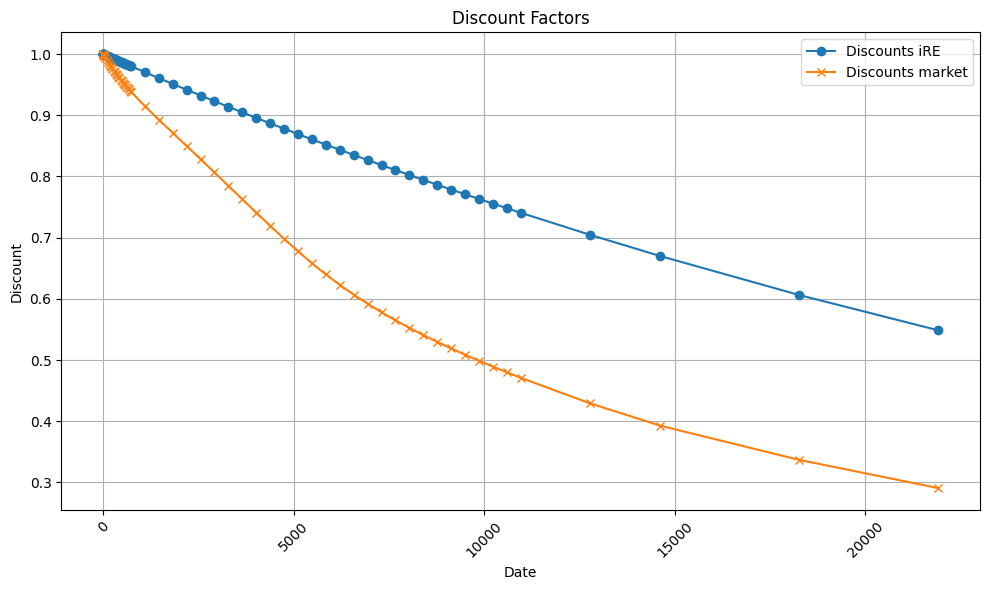

In [14]:
import matplotlib.pyplot as plt
estr_ire = bootstrapping_curve
discount_estr_ire = []
fwd_estr_ire = []
discounts_estr_mkt = ir_eur_disc_estr
for maturity in discounts_estr_mkt['daycount'].values/365:
    discount_estr_ire.append(estr_ire.discount(maturity))
    fwd_estr_ire.append(estr_ire.inst_fwd(maturity))
    
# Plot discount factors nostri vs market
plt.figure(figsize=(10, 6))
plt.plot(discounts_estr_mkt['daycount'].values, discount_estr_ire, label= 'Discounts iRE', marker='o', linestyle='-')
plt.plot(discounts_estr_mkt['daycount'].values, discounts_estr_mkt['market_quote'].values, label= 'Discounts market', marker='x', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Discount')
plt.title('Discount Factors')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Mostrare il grafico
plt.show()

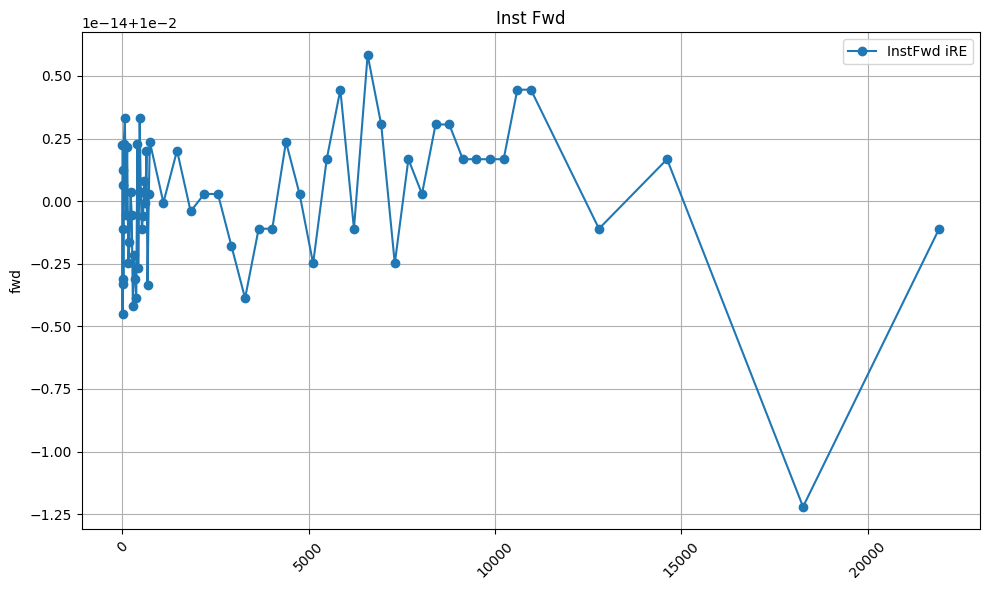

In [15]:
plt.figure(figsize=(10, 6))
plt.title('Inst Fwd')
plt.plot(discounts_estr_mkt['daycount'].values, fwd_estr_ire, label= 'InstFwd iRE', marker='o', linestyle='-')
plt.ylabel('fwd')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Mostrare il grafico
plt.show()